In [1]:
import sys
sys.path.insert(0, '..')

from mutators import *
from random import randrange, choice, random, uniform
from matplotlib import pyplot as plt
from numpy import sign
from cmath import phase
from math import ceil
from gp import GPTreebank
import operators as ops

In [2]:
type(MutatorFactory(int, 0.25))

mutators.IntMutator

In [3]:
type(MutatorFactory(bool, 0.25))

mutators.BoolMutator

In [4]:
type(MutatorFactory(float, 0.25, 1.25))

mutators.FloatMutator

In [5]:
type(MutatorFactory(complex, 0.25, 1.25))

mutators.ComplexMutator

In [2]:
class Counter(dict):
    def inc(self, key):
        self[key] = self.get(key, 0) +1

In [5]:
def test_im(*args):
    fig, axs = plt.subplots(len(args), 2)
    for i, mr in enumerate(args):
        ct_abs = Counter()
        ct_sign = Counter()
        im = MutatorFactory(np.int64, mr)
        for j in range(100000):
            val = randrange(-100, 100)
            delta = im(val) - val
            ct_abs.inc(abs(delta))
            ct_sign.inc(sign(delta))
        if len(args) > 1:
            axs[i, 0].bar(sorted(ct_abs.keys()), [ct_abs[k] for k in sorted(ct_abs.keys())])
            axs[i, 0].set_title(f'Absolute values, mutation rate = {mr}')
            axs[i, 1].bar(sorted(ct_sign.keys()), [ct_sign[k] for k in sorted(ct_sign.keys())])
            axs[i, 1].set_title(f'Signs, mutation rate = {mr}')
        else:
            axs[0].bar(sorted(ct_abs.keys()), [ct_abs[k] for k in sorted(ct_abs.keys())])
            axs[0].set_title(f'Absolute values, mutation rate = {mr}')
            axs[1].bar(sorted(ct_sign.keys()), [ct_sign[k] for k in sorted(ct_sign.keys())])
            axs[1].set_title(f'Signs, mutation rate = {mr}')
    fig.set_size_inches(18.5, len(args)*5, forward=True)

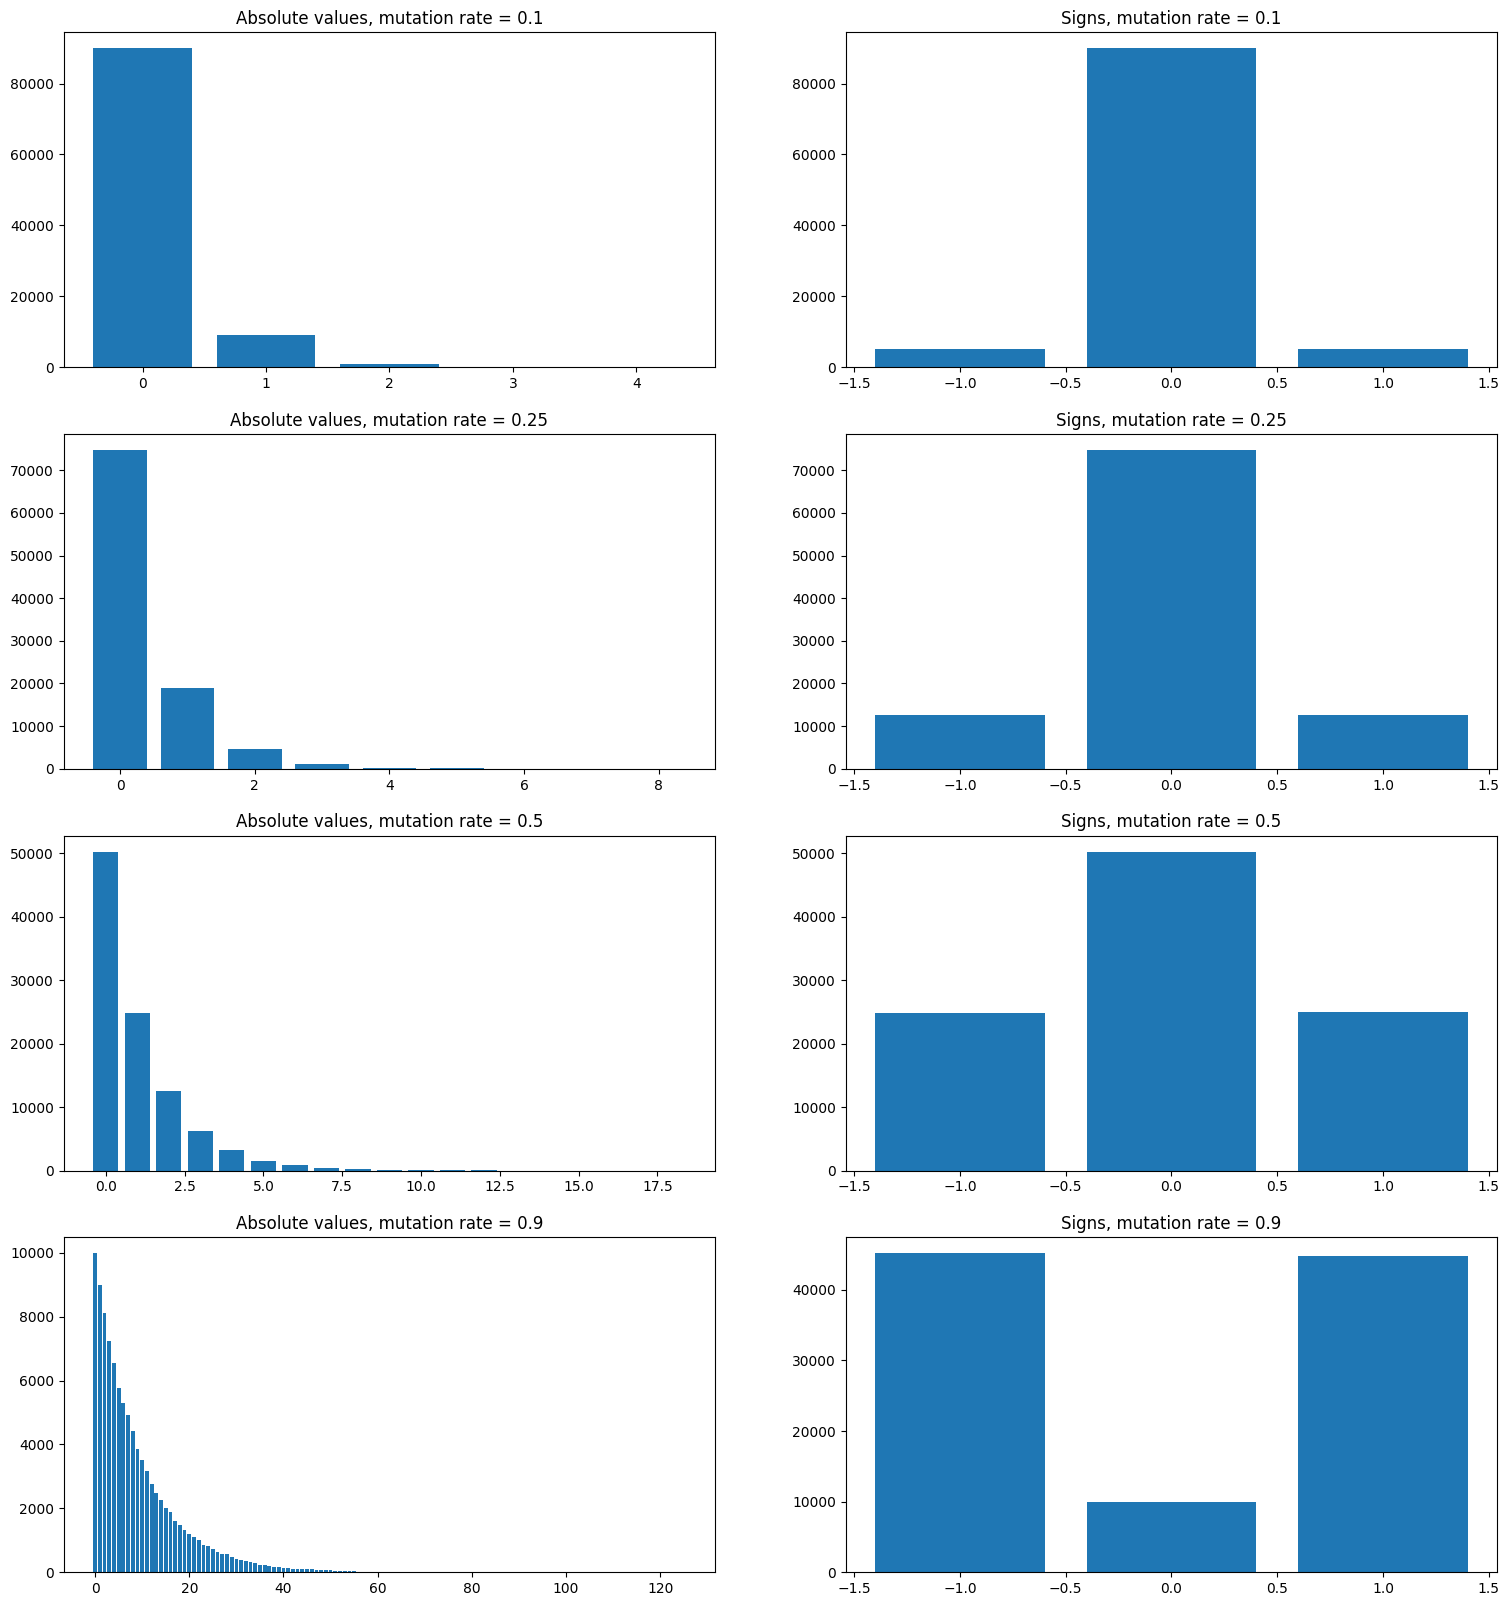

In [6]:
test_im(0.1, 0.25, 0.5, 0.9)

In [10]:
def test_mr(num_samples, sample_size, _type):
    fig, axs = plt.subplots(1,1)
    real_mr, est_mr = [], []
    for i in range(num_samples):
        real_mr.append(random())
        xm = MutatorFactory(_type, real_mr[-1], 1.0)
        mut_ct = 0.0
        for j in range(sample_size):
            if _type == np.bool_:
                val = np.bool_(choice([True, False]))
            elif _type == np.int64:
                val = np.int64(randrange(-100, 100))
            elif _type == np.float64:
                val = np.float64(uniform(-100.0, 100.0))
            elif _type == np.complex128:
                val = np.complex128(complex(uniform(-100.0, 100.0), uniform(-100.0, 100.0)))
            mut_ct += val != xm(val)
        est_mr.append(mut_ct/sample_size)
    axs.scatter(real_mr, est_mr)
    fig.set_size_inches(15, 15, forward=True)

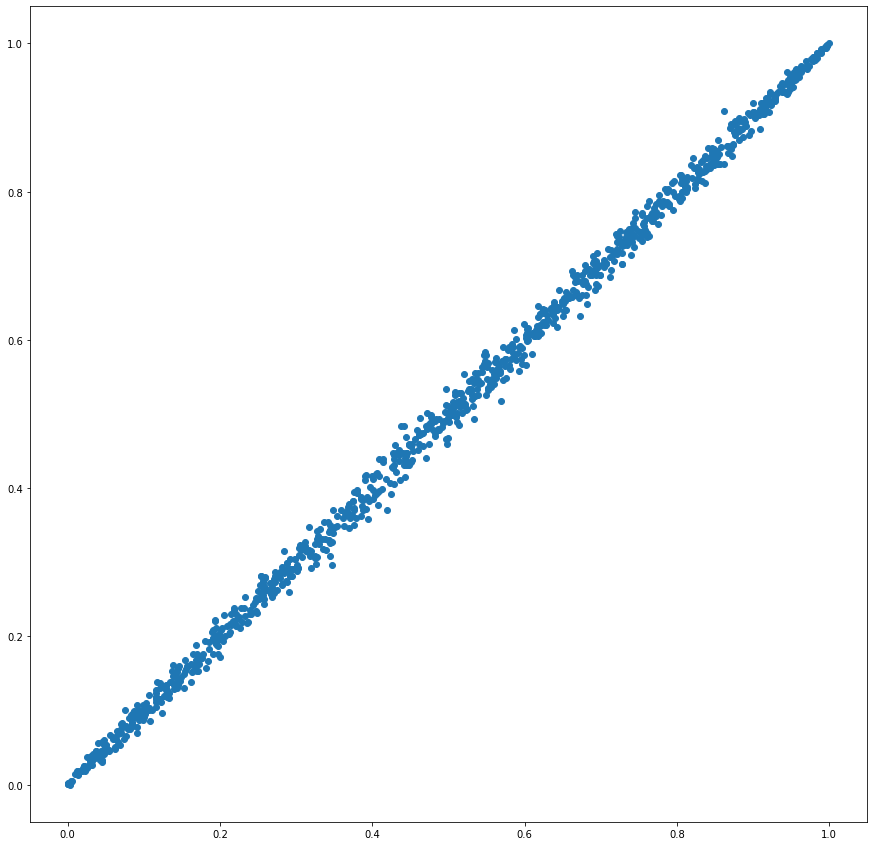

In [10]:
test_mr(1000, 1000, bool)

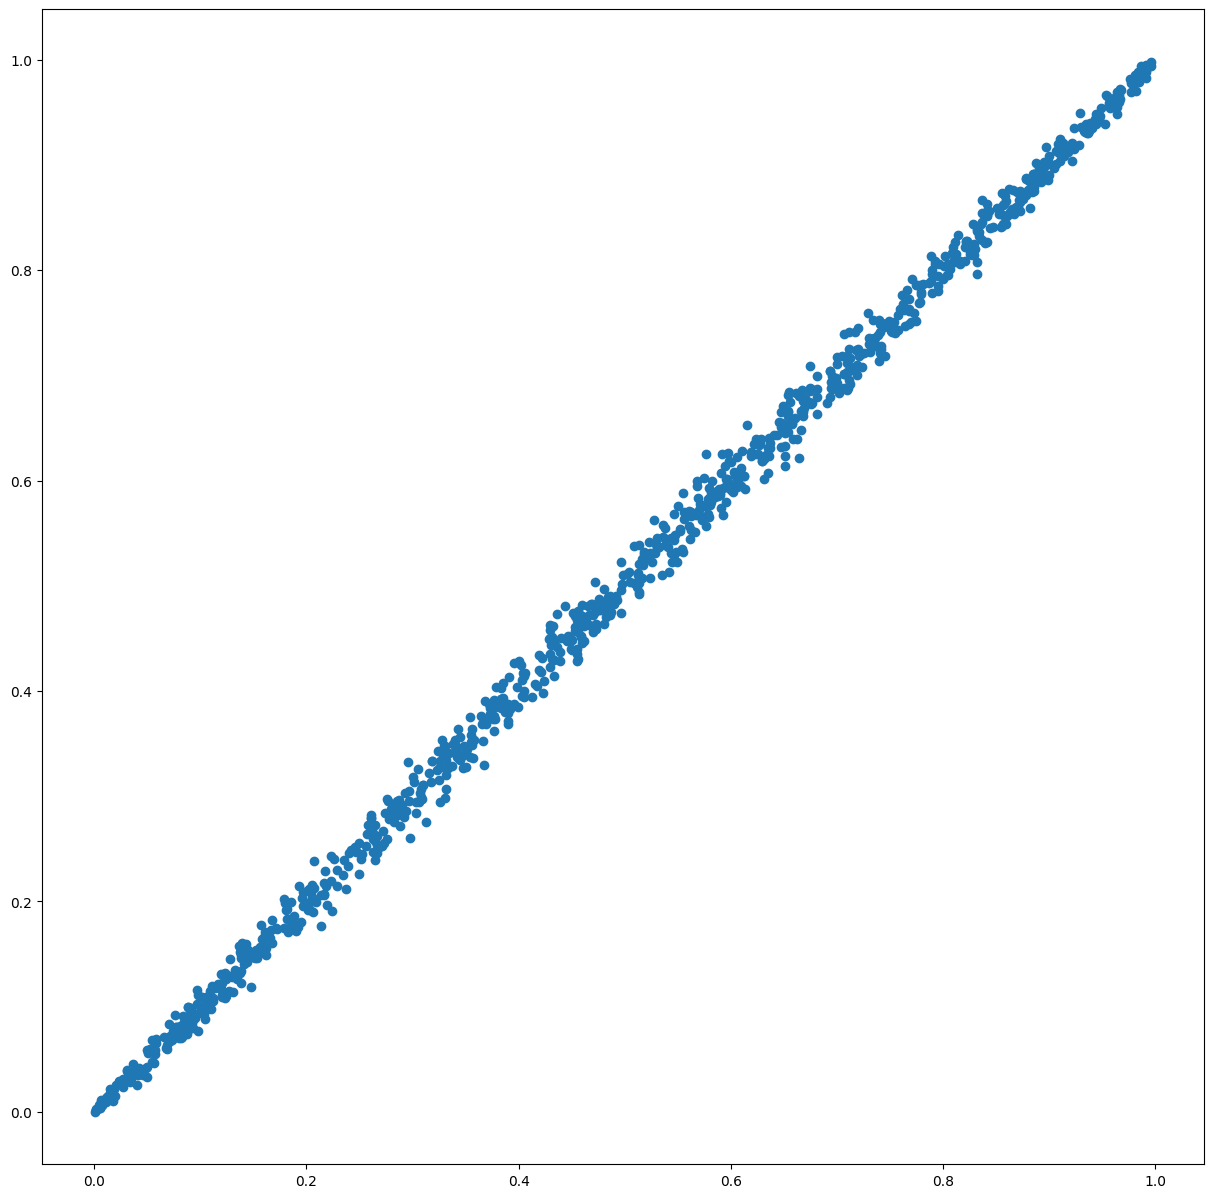

In [11]:
test_mr(1000, 1000, np.int64)

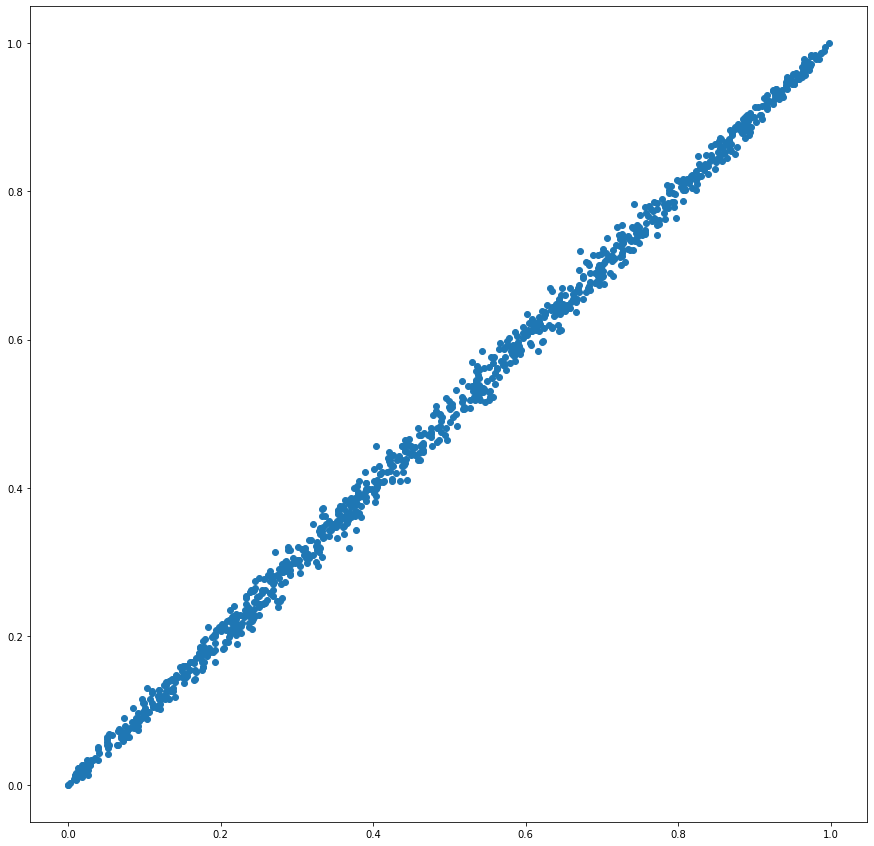

In [12]:
test_mr(1000, 1000, float)

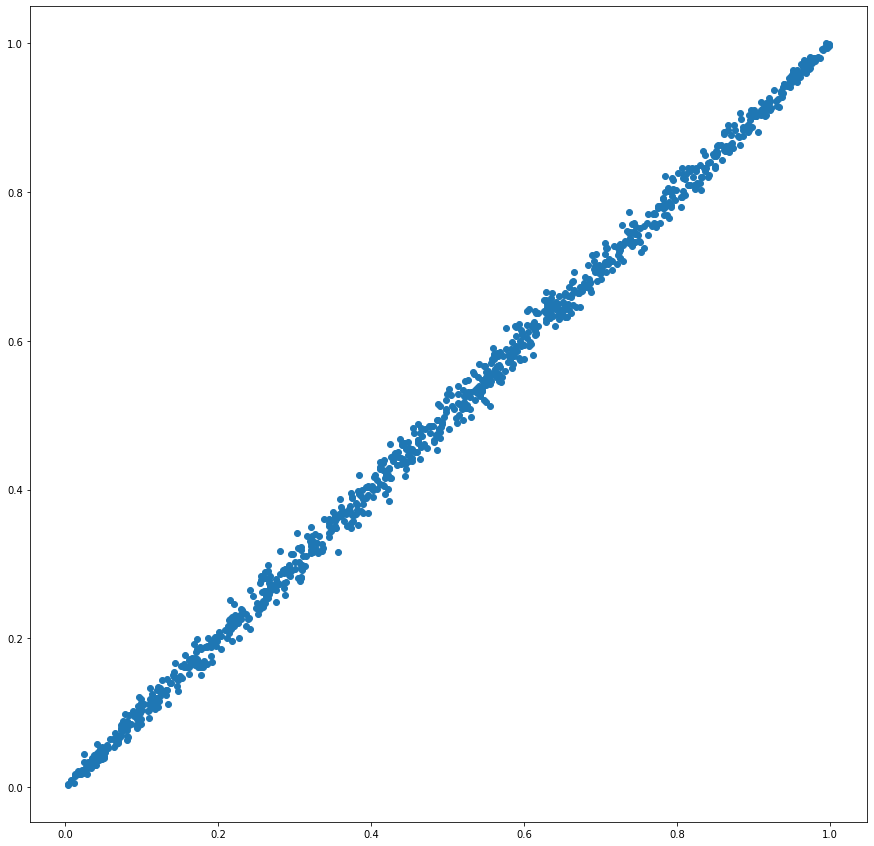

In [13]:
test_mr(1000, 1000, complex)

In [14]:
def test_fm(mrs, sds):
    fig, axs = plt.subplots(len(mrs), len(sds))
    for i, mr in enumerate(mrs):
        for j, sd in enumerate(sds):
            fm = MutatorFactory(float, mr, sd)
            deltas = []
            for x in range(int(100000//mr)):
                val = uniform(-100, 100)
                delta = fm(val) - val
                if delta != 0.0:
                    deltas.append(delta)
            if len(mrs) > 1 and len(sds) > 1:
                axs[i, j].hist(deltas, bins=100)
                axs[i, j].set_title(f'Moduli, sd = {sd}, mr = {mr}')
            else:
                axs[0].hist(deltas, bins=100)
                axs[0].set_title(f'Moduli, sd = {sd}, mr = {mr}')
    fig.set_size_inches(18.5, 18.5, forward=True)

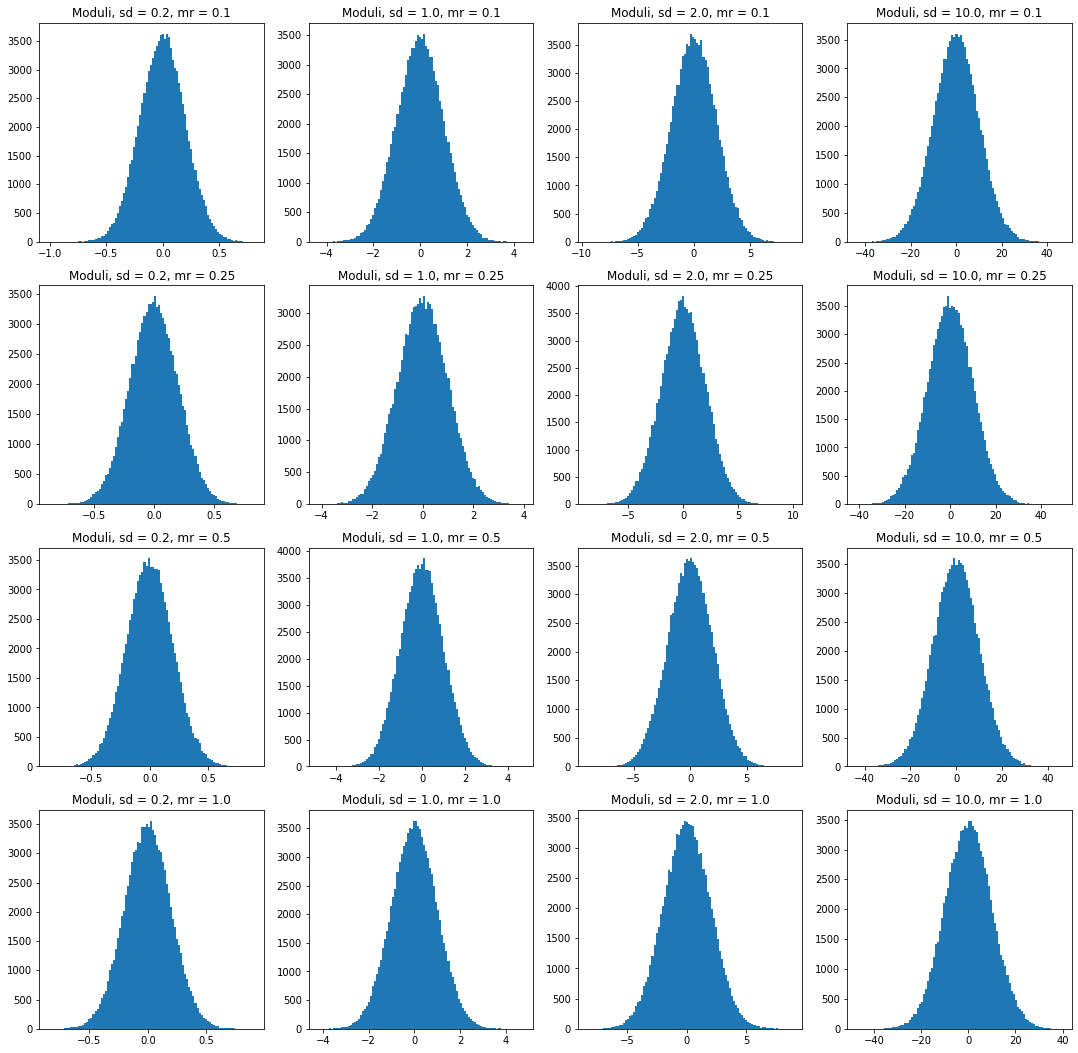

In [15]:
test_fm([0.1, .25, .5, 1.0], [0.2, 1.0, 2.0, 10.0])

In [16]:
def test_cm(mrs, sds):
    fig, axs = plt.subplots(ceil((len(mrs) * len(sds))/2), 4)
    fig.set_size_inches(18, 4.5 * ceil((len(mrs) * len(sds))/2), forward=True)
    for i, mr in enumerate(mrs):
        for j, sd in enumerate(sds):
            cm = MutatorFactory(complex, mr, sd)
            delta_mods = []
            delta_args = []
            for x in range(int(1000000//mr)):
                val = complex(uniform(-100, 100), uniform(-100, 100))
                delta = cm(val) - val
                if delta:
                    delta_mods.append(abs(delta))
                    delta_args.append(phase(delta))
            if len(mrs) > 1 and len(sds) > 1:
                axs[int((((len(sds)*i)+j)*2)//4), (((len(sds)*i)+j)*2)%4].hist(delta_mods, bins=100)
                axs[int((((len(sds)*i)+j)*2)//4), (((len(sds)*i)+j)*2)%4].set_title(f'Moduli, sd = {sd}, mr = {mr}')
                axs[int(((((len(sds)*i)+j)*2)+1)//4), ((((len(sds)*i)+j)*2)+1)%4].hist(delta_args, bins=100)
                axs[int(((((len(sds)*i)+j)*2)+1)//4), ((((len(sds)*i)+j)*2)+1)%4].set_title(f'Arguments, sd = {sd}, mr = {mr}')
            else:
                axs[0].hist(delta_mods, bins=100)
                axs[0].set_title(f'Moduli, sd = {sd}, mr = {mr}')
    

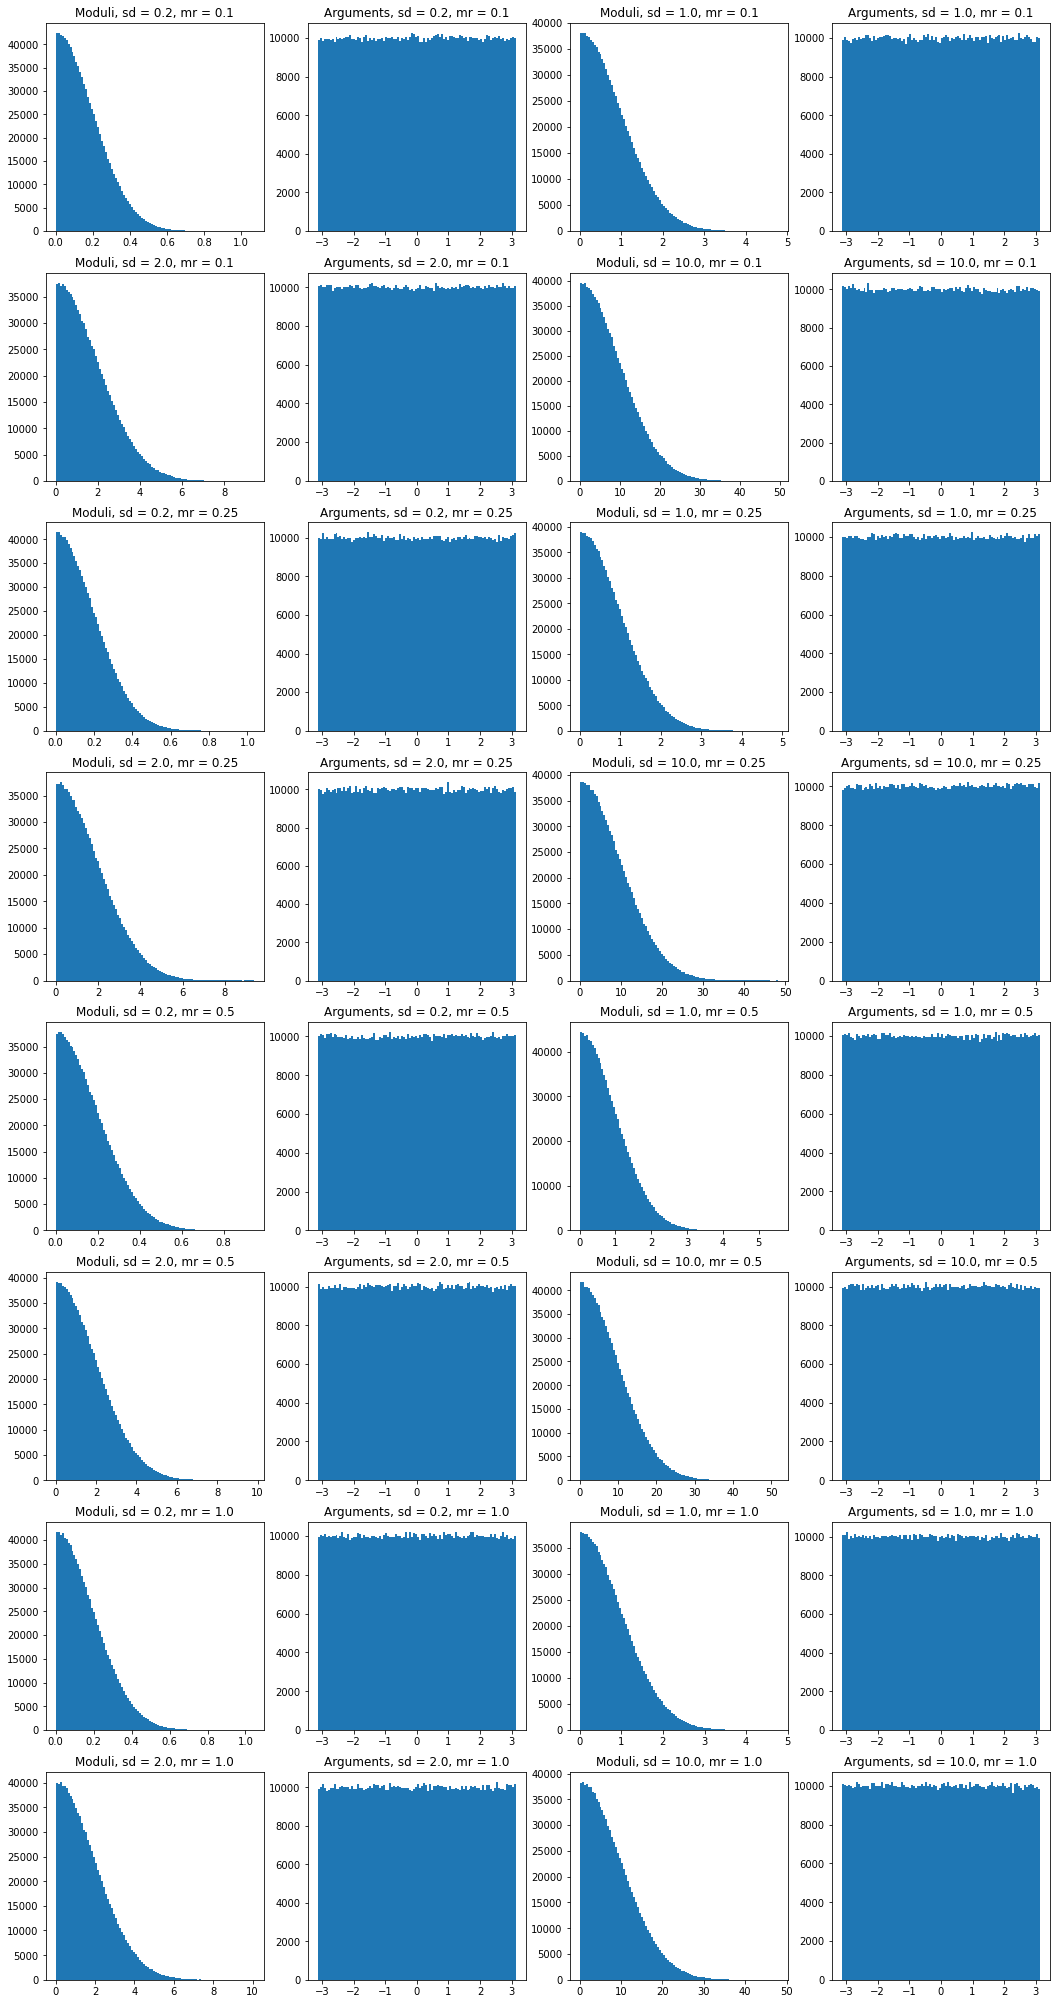

In [17]:
test_cm([0.1, .25, .5, 1.0], [0.2, 1.0, 2.0, 10.0])

In [18]:
gp = GPTreebank(mutation_rate=0, mutation_sd=0, crossover_rate=0.5, operators=[ops.EQ])

In [19]:
t5 = gp.tree("([bool]<EQ>([float]5.0)([int]5))")
t9 = gp.tree("([bool]<EQ>([float]9.0)([int]9))")

([bool]<EQ>([float]5.0)([int]5))
You tried to set a <class 'trees.TypeLabel'>, [bool] as a child of the Tree (). You should have used a Tree


TypeError: You tried to set a <class 'trees.TypeLabel'>, [bool] as a child of the Tree (). You should have used a Tree